***
## Reading data and preparing vectors
***

In [1]:
import numpy as np
import pdb
import gzip
import matplotlib
import matplotlib.pyplot as plt
import cPickle as pkl
import operator
import scipy.io as sio
import os.path
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from data_preprocess import *
np.random.seed(23254)

dataset = 'ciao'
thres = 0.5
perplexity = 30
numSubset = 200
print("Dataset: {}, Thres: {}, Perplexity: {}, numSubset: {}".format(dataset, thres, perplexity, numSubset))

df_data, total_uids, total_iids, train_uids, train_iids, userCache, itemCache, uid_map, iid_map = readData(dataset)

df_data, cat_map, category_map_inv, mappedIid_mappedCat, category_map = extractCategory(dataset, df_data, iid_map)

df_data['cat'] = df_data['iid'].map(cat_map)
df_data['uid'] = df_data['uid'].map(uid_map)
df_data['iid'] = df_data['iid'].map(iid_map)
df_data = df_data.sort_values(['uid','iid']).reset_index(drop=True)

itemEmbedding_CML, itemEmbedding_TransCF, translation_vecs_TransCF, translation_vecs_CML, translation_vecs_TransCF_emb, ratings, translation_vecs_TransCF_categories, translation_vecs_CML_categories, translation_vecs_TransCF_emb_categories, categories = getEmbeddings(dataset, df_data, total_uids, total_iids, train_uids, train_iids, userCache, itemCache)

translation_vecs_TransCF, translation_vecs_CML, translation_vecs_TransCF_emb, ratings = preprocessRatings(translation_vecs_TransCF, translation_vecs_CML, translation_vecs_TransCF_emb, ratings)
translation_vecs_TransCF_categories, translation_vecs_CML_categories, translation_vecs_TransCF_emb_categories, categories, itemEmbedding_CML, itemEmbedding_TransCF, categories_emb = preprocessCategories(dataset, itemEmbedding_CML, itemEmbedding_TransCF, translation_vecs_TransCF_categories, translation_vecs_CML_categories, translation_vecs_TransCF_emb_categories, categories, category_map_inv, mappedIid_mappedCat, category_map)


# filter for translation vectors
## Ratings
translation_vecs_TransCF, translation_vecs_CML, translation_vecs_TransCF_emb, ratings = balanceData(translation_vecs_TransCF, translation_vecs_CML, translation_vecs_TransCF_emb, ratings, False)
## Categories
translation_vecs_TransCF_categories, translation_vecs_CML_categories, translation_vecs_TransCF_emb_categories, categories = balanceData(translation_vecs_TransCF_categories, translation_vecs_CML_categories, translation_vecs_TransCF_emb_categories, categories, True)

# filter categories for embeddings
itemEmbedding_TransCF, itemEmbedding_CML, categories_emb = balanceData_emb(itemEmbedding_TransCF, itemEmbedding_CML, categories_emb)

print("***Done Preparing Data***")

Dataset: ciao, Thres: 0.5, Perplexity: 30, numSubset: 200
- Top-10 Categories Trans: ['Ciao Cafe', 'DVDs', 'Internet', 'Food & Drink', 'Beauty', 'Games', 'Entertainment', 'Travel', 'Music', 'Shopping']
- Top-10 Categories Emb: ['DVDs', 'Beauty', 'Food & Drink', 'Ciao Cafe', 'Games', 'Travel', 'Books', 'Music', 'Internet', 'Entertainment']
***Done Preparing Data***


***
## Classification
***

In [2]:
# Classification (Rating and Category)
def scoring(clf, translation_vecs_CML, translation_vecs_TransCF_emb, translation_vecs_TransCF, labels, rand=False):
    
    if rand == True:
        scores = cross_val_score(clf, translation_vecs_CML, labels, cv=5, n_jobs=-1)
        print("Accuracy: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std() * 2))
    else:
        scores = cross_val_score(clf, translation_vecs_CML, labels, cv=5, n_jobs=-1)
        print("[CML] Accuracy: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std() * 2))
        if len(translation_vecs_TransCF_emb) != 0:
            scores = cross_val_score(clf, translation_vecs_TransCF_emb, labels, cv=5, n_jobs=-1)
            print("[TransCF_emb] Accuracy: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std() * 2))
        scores = cross_val_score(clf, translation_vecs_TransCF, labels, cv=5, n_jobs=-1)
        print("[TransCF] Accuracy: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std() * 2))

        
def classification(translation_vecs_CML, translation_vecs_TransCF_emb, translation_vecs_TransCF, labels):        
    print("===Random Guess===")
    clf = DummyClassifier()
    scoring(clf, translation_vecs_CML, translation_vecs_TransCF_emb, translation_vecs_TransCF, labels, True)


    print("===Random Forest===")
    clf = RandomForestClassifier(n_estimators=300, n_jobs=-1)
    scoring(clf, translation_vecs_CML, translation_vecs_TransCF_emb, translation_vecs_TransCF, labels)

    
# Classify ratings
print("[Classification for ratings]")
classification(translation_vecs_CML, translation_vecs_TransCF_emb, translation_vecs_TransCF, ratings)

# Classify categories
print("\n[Classify Categories for translation vectors]")
classification(translation_vecs_CML_categories, translation_vecs_TransCF_emb_categories, translation_vecs_TransCF_categories, categories)
print("\n[Classify Categories using item embedding vectors]")
classification(itemEmbedding_CML, [], itemEmbedding_TransCF, categories_emb)
print("***Done Classifications***")

[Classification for ratings]
===Random Guess===
Accuracy: 0.1995 (+/- 0.0002)
===Random Forest===
[CML] Accuracy: 0.5034 (+/- 0.0058)
[TransCF_emb] Accuracy: 0.5039 (+/- 0.0086)
[TransCF] Accuracy: 0.5302 (+/- 0.0058)

[Classify Categories for translation vectors]
===Random Guess===
Accuracy: 0.1001 (+/- 0.0000)
===Random Forest===
[CML] Accuracy: 0.6786 (+/- 0.0047)
[TransCF_emb] Accuracy: 0.6727 (+/- 0.0028)
[TransCF] Accuracy: 0.8097 (+/- 0.0073)

[Classify Categories using item embedding vectors]
===Random Guess===
Accuracy: 0.1092 (+/- 0.0037)
===Random Forest===
[CML] Accuracy: 0.8041 (+/- 0.0159)
[TransCF] Accuracy: 0.8161 (+/- 0.0154)
***Done Classifications***


***
## Filtering
* This is to select candidates for plotting.
    + We select from correctly classified samples by a certain confidence `thres`.
    + We can skip this process and get similar t-SNE results.
***

In [3]:
from sklearn.model_selection import StratifiedKFold
def classification_for_filtering(X, y):
    skf = StratifiedKFold(n_splits=5)
    new_X = []
    new_y = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        clf = RandomForestClassifier(n_estimators=300, n_jobs=-1).fit(X_train, y_train)
        
        prob = clf.predict_proba(X_test)
        y_test_pred = clf.predict(X_test)
        
        # Filter only correct ones
        correct_idx = np.equal(y_test, y_test_pred)
        X_test = X_test[correct_idx]
        y_test = y_test[correct_idx]
        prob = prob[correct_idx]
        
        threshold = np.amax(prob, axis=1)
        
        X_test = X_test[threshold>thres].tolist()
        y_test = y_test[threshold>thres].tolist()
        
        new_X += X_test
        new_y += y_test
    
    new_X = np.array(new_X)
    new_y = np.array(new_y)
    
    return new_X, new_y


# Filtering candidates for plotting by classification
# Trans
translation_vecs_TransCF_categories, categories_TransCF = classification_for_filtering(translation_vecs_TransCF_categories, categories)
translation_vecs_TransCF_categories, _, _, categories_TransCF = balanceData(translation_vecs_TransCF_categories, [], [], categories_TransCF, cat=True)

# CML
translation_vecs_CML_categories, categories_CML = classification_for_filtering(translation_vecs_CML_categories, categories)
translation_vecs_CML_categories, _, _, categories_CML = balanceData(translation_vecs_CML_categories, [], [], categories_CML, cat=True)
print("***Done filtering for TSNE***")

***Done filtering for TSNE***


***
## t-SNE Plotting
***

In [4]:
# Plot TSNE
print("Start TSNE")
from MulticoreTSNE import MulticoreTSNE as TSNE

# TSNE Categories
X_TSNE_TransCF = TSNE(perplexity=perplexity, n_jobs=8).fit_transform(translation_vecs_TransCF_categories)
X_TSNE_CML = TSNE(perplexity=perplexity, n_jobs=8).fit_transform(translation_vecs_CML_categories)
print("Done TSNE")

Start TSNE
Done TSNE


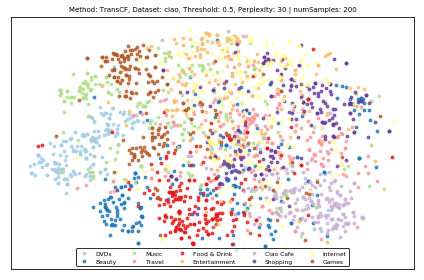

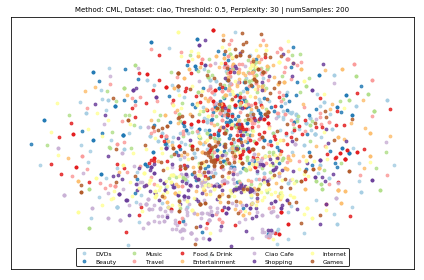

In [5]:
colormap = 'Paired'

def select_subset(n, X_heatmap, X_TSNE, y):
    X_small_TSNE = []
    X_small_heatmap = []
    y_small = []
    
    minVal = 10000000
    # get min num val
    for elem in np.unique(y):
        tmp = np.sum(y == elem)
        if tmp < minVal:
            minVal = tmp
            
    if n > minVal:
        n= minVal
    
    for elem in np.unique(y):
        idxs = np.random.choice(np.where((y == elem))[0], n)
        X_small_TSNE += X_TSNE[idxs].tolist()
        X_small_heatmap += X_heatmap[idxs].tolist()
        y_small += y[idxs].tolist()
    
    cat_dict = dict()
    for x,y in zip(X_small_heatmap,y_small):
        cat_dict.setdefault(y,[]).append(x)
        
    X_small = np.array(X_small_TSNE)    
    y_small = np.array(y_small)
    
    
    
    return X_small, y_small, n, cat_dict

def plot_result(method, xs, ys, labels, numSamples): 
    lab_idx = dict()
    for idx, lab in enumerate(set(labels)):
        lab_idx[category_map_inv[lab]] = idx
        
    cmap = plt.get_cmap(colormap)
    colors = cmap(np.linspace(0, 1, len(set(labels))))
    
    lst = [0]*len(set(labels))
    fig = plt.figure(edgecolor='black')
    for x,y,lab in zip(xs,ys,labels):
        plt.scatter(x,y,s=8,c=colors[lab_idx[category_map_inv[lab]]],label=category_map_inv[lab] if lst[lab_idx[category_map_inv[lab]]] == 0 else "", alpha=0.8)
        lst[lab_idx[category_map_inv[lab]]] = 1
    plt.legend(fontsize=6,ncol=5,edgecolor='black',loc='lower center')
    
    plt.title('Method: {}, Dataset: {}, Threshold: {}, Perplexity: {} | numSamples: {}'.format(method, dataset, thres, perplexity, numSamples),fontsize=7)
    plt.xticks([], [])
    plt.yticks([], [])
    plt.tight_layout()
    plt.show()

import os.path
def final_plot(X, X_TSNE, y, method):
    X_TSNE_small, y_small, numSamples, cat_dict = select_subset(numSubset, X, X_TSNE, y)
    
    plot_result(method, X_TSNE_small[:,0],X_TSNE_small[:,1],y_small,numSamples)

    return cat_dict

cat_dict_TransCF = final_plot(translation_vecs_TransCF_categories, X_TSNE_TransCF, categories_TransCF, 'TransCF')
cat_dict_CML = final_plot(translation_vecs_CML_categories, X_TSNE_CML, categories_CML, 'CML')

***
## Draw Heat map
***

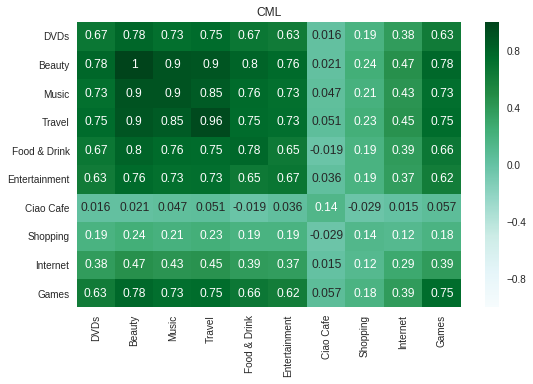

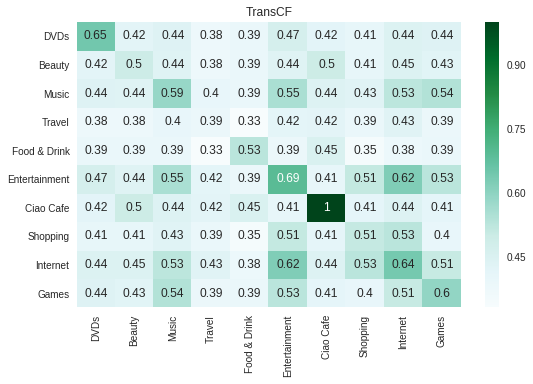

In [6]:
from scipy import spatial

def calc_correlation(cat_dict):
    correlation_dict = dict()
    already = set()
    for cat in cat_dict.keys():
        for cat_ in cat_dict.keys():
            if cat_ in already:
                continue
            already.add(cat)
            # print("Cat1: {} | Cat2: {}".format(cat,cat_))
            for target in cat_dict[cat]:
                for target2 in cat_dict[cat_]:
                    result = 1 - spatial.distance.cosine(target, target2)
                    correlation_dict.setdefault((cat,cat_),0.0)
                    correlation_dict[(cat,cat_)] += result
    
    return correlation_dict

import seaborn as sns
def draw_heatmap(result, categories, method):
    max_ = 0
    lst = []
    real_cats = []
    for cat1 in categories:
        real_cats.append(category_map_inv[cat1])
        tmp = []
        for cat2 in categories:
            try:
                val = result[(cat1,cat2)]
            except:
                val = result[(cat2,cat1)]
            if val > max_:
                max_ = val
            tmp.append(val)
        lst.append(tmp)
    
    lst = np.array(lst) / float(max_)
    # plot the heatmap
    cmap = 'BuGn'
    plt.figure()
    sns.heatmap(lst, xticklabels=real_cats, yticklabels=real_cats, cmap=cmap,annot=True)
    plt.xticks(rotation=90)
    plt.yticks(rotation=360)
    plt.title(method)
    plt.tight_layout()
    plt.show()

# CML
result = calc_correlation(cat_dict_CML)
categories = cat_dict_CML.keys()
draw_heatmap(result,categories,"CML")

# TransCF
result = calc_correlation(cat_dict_TransCF)
categories = cat_dict_TransCF.keys()
draw_heatmap(result,categories,"TransCF")